In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2

In [2]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [3]:
#Creating the Landmark object
base_options = python.BaseOptions(model_asset_path='../models/pose_landmarker_heavy.task')
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    running_mode=vision.RunningMode.VIDEO,
    min_pose_detection_confidence=0.6,
    min_pose_presence_confidence=0.7,
    min_tracking_confidence=0.95,
)
detector = vision.PoseLandmarker.create_from_options(options)

In [4]:
VIDEO_PATH    = "../data/raw"
OUTPUT_PATH   = "../outputs"
FILE_NAME = "video_4"
FILE_PATH = os.path.join(VIDEO_PATH, FILE_NAME + ".mp4")

cap = cv2.VideoCapture(FILE_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {FILE_PATH}")

fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')              # or 'avc1', 'XVID', etc.
out    = cv2.VideoWriter(os.path.join(OUTPUT_PATH, FILE_NAME + ".mp4"), fourcc, fps, (width, height))

keypoints = []
frame_idx = 0

while True:
    success, frame_bgr = cap.read()
    if not success:
        break
    
    frame_idx += 1
    
    frame_rgb  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_image   = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
    result     = detector.detect_for_video(mp_image, timestamp_ms)
    if not result.pose_landmarks:
        print(f"No pose landmarks detected in frame {frame_idx}")
        continue

    if result.pose_landmarks:
        lm = result.pose_landmarks[0]
        coords = np.array(
            [[l.x, l.y, l.z] for l in lm],
            dtype=np.float32
        )
    else:
        coords = np.zeros((len(solutions.pose.PoseLandmark), 3), dtype=np.float32)

    keypoints.append(coords)

    annotated_rgb = draw_landmarks_on_image(frame_rgb, result)
    annotated_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)

    out.write(annotated_bgr)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Saved annotated video to {os.path.join(OUTPUT_PATH, FILE_NAME + '.mp4')}")


No pose landmarks detected in frame 60
No pose landmarks detected in frame 62
No pose landmarks detected in frame 65
No pose landmarks detected in frame 66
No pose landmarks detected in frame 69
No pose landmarks detected in frame 99
No pose landmarks detected in frame 174
No pose landmarks detected in frame 175
No pose landmarks detected in frame 181
No pose landmarks detected in frame 190
No pose landmarks detected in frame 200
No pose landmarks detected in frame 207
Saved annotated video to ../outputs\video_4.mp4


# Phase Segmentation

In [5]:
import os

kp_array = np.stack(keypoints, axis=0)  # shape = (F, L, 3)
os.makedirs(os.path.dirname("D:/Projects/TrueForm/data/keypoints"), exist_ok=True)
np.save(f"D:/Projects/TrueForm/data/keypoints/{FILE_NAME}_landmarks.npy", kp_array)
print(f"Saved landmarks array to {os.path.join('D:/Projects/TrueForm/data/keypoints', f'{FILE_NAME}_landmarks.npy')}")

Saved landmarks array to D:/Projects/TrueForm/data/keypoints\video_4_landmarks.npy


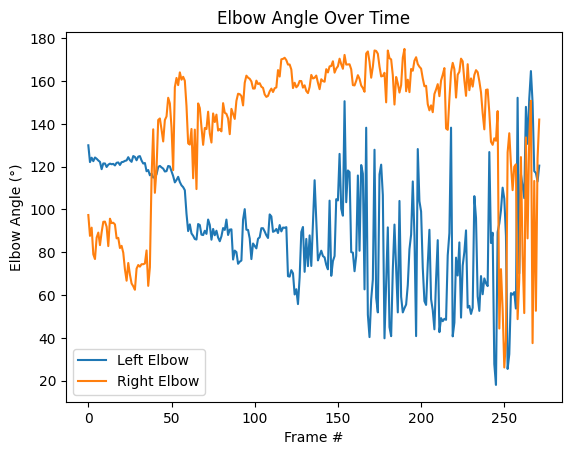

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt


def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    cos_ang = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return math.degrees(math.acos(np.clip(cos_ang, -1.0, 1.0)))

landmarks = np.load(f'../data/keypoints/{FILE_NAME}_landmarks.npy')  # shape (F,33,3)
F = landmarks.shape[0]

# Preallocating arrays for angles
left_elbow = np.zeros(F)
right_elbow = np.zeros(F)


L = solutions.pose.PoseLandmark

for i in range(F):
    coords = landmarks[i]
    left_elbow[i]  = angle_between(
        coords[L.LEFT_SHOULDER.value],
        coords[L.LEFT_ELBOW.value],
        coords[L.LEFT_WRIST.value]
    )
    right_elbow[i] = angle_between(
        coords[L.RIGHT_SHOULDER.value],
        coords[L.RIGHT_ELBOW.value],
        coords[L.RIGHT_WRIST.value]
    )

# Plot
plt.figure()
plt.plot(range(F), left_elbow, label='Left Elbow')
plt.plot(range(F), right_elbow, label='Right Elbow')
plt.xlabel('Frame #')
plt.ylabel('Elbow Angle (°)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()

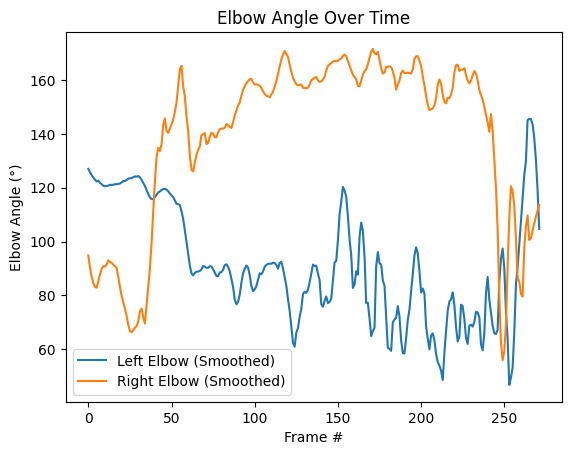

In [7]:
from scipy.signal import savgol_filter
from scipy.signal import find_peaks


window_length = 11  # must be odd, and < len(signal)
polyorder     = 2

left_smooth  = savgol_filter(left_elbow,  window_length, polyorder)
right_smooth = savgol_filter(right_elbow, window_length, polyorder)

plt.figure()
plt.plot(range(F), left_smooth, label='Left Elbow (Smoothed)')
plt.plot(range(F), right_smooth, label='Right Elbow (Smoothed)')
plt.xlabel('Frame #')
plt.ylabel('Elbow Angle (°)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()

In [8]:
peaks, props = find_peaks(left_smooth, height=155, distance=60)
# – height=155° ensures we only pick “full-draw” peaks
# – distance=30 frames separates shots by at least 1 second (if 30 fps)

print(f"Detected {len(peaks)} shots at frames {peaks}")

Detected 0 shots at frames []


In [9]:
from scipy.signal import savgol_filter, find_peaks

# PARAMETERS (tweak)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
min_shot_sep_s = 0.7               # minimum seconds between shots (0.7s default)
min_prominence = 8.0               # degrees (or signal units) that a peak must stand out by
min_width_frames = int(0.05 * fps) # minimal width of peak in frames (e.g., 50 ms)
min_hold_frames = int(0.08 * fps)  # require short hold (~80 ms) — tune as needed

# right_smooth is your primary signal (e.g., smoothed elbow angle/time series)
# 1) smooth more reliably with Savitzky-Golay
win = 7 if len(right_smooth) > 7 else (len(right_smooth) // 2 * 2 + 1)
right_sg = savgol_filter(right_smooth, window_length=win, polyorder=2)

# 2) adaptive height baseline: require peaks above e.g. 80th percentile (optional)
height_threshold = np.percentile(right_sg, 80)

# 3) find candidate peaks using prominence + width + distance (in frames)
peaks, props = find_peaks(
    right_sg,
    prominence=min_prominence,
    width=min_width_frames,
    distance=int(min_shot_sep_s * fps),
    height=height_threshold
)

# 4) optional extra validation using wrist velocity and hold stability
# compute wrist angle or wrist position speed (example: left wrist y-velocity)
# assume wrist_y is an array of normalized y positions per frame
wrist_y = landmarks[:, L.RIGHT_WRIST.value, 1]  # normalized Y (replace if needed)
wrist_speed = np.abs(np.gradient(wrist_y)) * fps    # approx px/sec in normalized units

valid_peaks = []
for pk in peaks:
    # require a brief low-velocity "hold" before the peak
    hold_start = max(0, pk - min_hold_frames)
    hold_window_speed = np.nanmean(wrist_speed[hold_start:pk]) if pk>hold_start else np.inf

    # require a release spike after the peak (jerk): mean speed in small window after peak should be larger
    post_window = wrist_speed[pk: min(len(wrist_speed), pk + int(0.12*fps))]
    post_mean = np.nanmean(post_window) if len(post_window)>0 else 0.0

    # heuristic conditions
    if hold_window_speed < 0.01 and post_mean > 0.02:
        valid_peaks.append(pk)
    else:
        # weaker fallback: accept if the peak has strong prominence/width
        if props['prominences'][np.where(peaks==pk)[0][0]] > (min_prominence * 1.5):
            valid_peaks.append(pk)

# final peaks
peaks = np.array(valid_peaks, dtype=int)
print(f"Detected {len(peaks)} shots at frames {peaks}")


Detected 4 shots at frames [ 56 118 172 222]


In [10]:
shot_metrics = []
for p in peaks:
    # find where this draw started (local trough before p)
    start = np.argmin(left_smooth[max(0, p-50):p]) + max(0, p-50)
    peak_angle = left_smooth[p]
    hold_var   = np.std(left_smooth[p-10:p])
    pull_rate  = (peak_angle - left_smooth[start]) / (p - start)
    shot_metrics.append({
        "frame_start": start,
        "frame_peak" : p,
        "peak_angle" : peak_angle,
        "hold_variance": hold_var,
        "pull_rate": pull_rate,
    })

In [11]:
shot_metrics

[{'frame_start': np.int64(55),
  'frame_peak': np.int64(56),
  'peak_angle': np.float64(111.29987969407745),
  'hold_variance': np.float64(2.177952699209789),
  'pull_rate': np.float64(-2.2773539350927336)},
 {'frame_start': np.int64(89),
  'frame_peak': np.int64(118),
  'peak_angle': np.float64(86.73191044227747),
  'hold_variance': np.float64(0.821161566206687),
  'pull_rate': np.float64(0.3455593694754722)},
 {'frame_start': np.int64(124),
  'frame_peak': np.int64(172),
  'peak_angle': np.float64(67.98291344389813),
  'hold_variance': np.float64(15.057269083975505),
  'pull_rate': np.float64(0.14645073646072712)},
 {'frame_start': np.int64(213),
  'frame_peak': np.int64(222),
  'peak_angle': np.float64(62.87635542145445),
  'hold_variance': np.float64(10.99280903848258),
  'pull_rate': np.float64(1.5881355995172584)}]

In [12]:
import pandas as pd

# --- 1) Build DataFrame from your list of dicts:
df = pd.DataFrame(shot_metrics)
df.index.name = "shot_idx"

# --- 2) Add right-arm peak angle & symmetry difference:
# (we’ll assume the same peak frames correspond on right side)
df['peak_angle_R'] = right_smooth[df['frame_peak']]
df['symmetry_diff'] = (df['peak_angle'] - df['peak_angle_R']).abs()

# --- 3) Shot duration (frames → seconds):
df['duration_s'] = (df['frame_peak'] - df['frame_start']) / fps

# --- 4) Consistency score (higher = steadier hold):
# simple example: 1 / (1 + hold_variance)
df['consistency_score'] = 1.0 / (1.0 + df['hold_variance'])

# Quick look:
print(df[['frame_start','frame_peak',
          'peak_angle','peak_angle_R','symmetry_diff',
          'hold_variance','pull_rate','duration_s','consistency_score']])


          frame_start  frame_peak  peak_angle  peak_angle_R  symmetry_diff  \
shot_idx                                                                     
0                  55          56  111.299880    165.270930      53.971050   
1                  89         118   86.731910    170.806744      84.074834   
2                 124         172   67.982913    169.976943     101.994030   
3                 213         222   62.876355    165.720611     102.844256   

          hold_variance  pull_rate  duration_s  consistency_score  
shot_idx                                                           
0              2.177953  -2.277354    0.033333           0.314668  
1              0.821162   0.345559    0.966667           0.549100  
2             15.057269   0.146451    1.600000           0.062277  
3             10.992809   1.588136    0.300000           0.083383  


In [13]:
def dist(a, b):
    return np.linalg.norm(a - b)

# for each shot, measure ankle‐to‐ankle distance at the peak frame
stance_widths = []
for _, row in df.iterrows():
    coords = landmarks[int(row['frame_peak'])]
    lw = coords[L.LEFT_ANKLE.value]
    rw = coords[L.RIGHT_ANKLE.value]
    stance_widths.append(dist(lw, rw))

df['stance_width'] = stance_widths

# View updated table
print(df[['peak_angle','symmetry_diff','stance_width']])


          peak_angle  symmetry_diff  stance_width
shot_idx                                         
0         111.299880      53.971050      0.574497
1          86.731910      84.074834      0.268410
2          67.982913     101.994030      0.056598
3          62.876355     102.844256      0.282296


In [14]:
df.to_csv(f'../data/metrics/{FILE_NAME}_shot_metrics.csv')

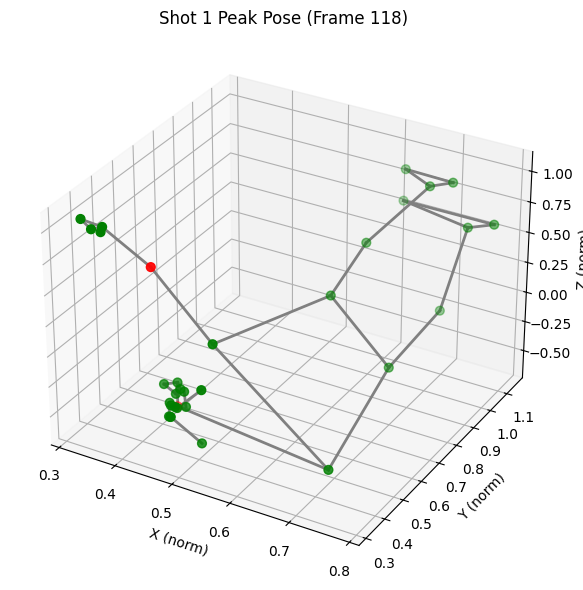

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mediapipe import solutions

# Paths (adjust if needed)
LANDMARKS_PATH = f'../data/keypoints/{FILE_NAME}_landmarks.npy'
METRICS_PATH   = f'../data/metrics/{FILE_NAME}_shot_metrics.csv'

# Load data
landmarks = np.load(LANDMARKS_PATH)  # shape = (F,33,3)
df        = pd.read_csv(METRICS_PATH, index_col='shot_idx')

# Map PoseLandmark enum and connections
L = solutions.pose.PoseLandmark
connections = solutions.pose.POSE_CONNECTIONS

# Choose the shot index to visualize (e.g. shot_idx = 1)
shot_idx   = 1
shot       = df.loc[shot_idx]
frame_peak = int(shot['frame_peak'])
coords     = landmarks[frame_peak]    # (33, 3) array

# Build a per‐landmark color array
colors = []
for lm_idx in range(coords.shape[0]):
    if lm_idx in (L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value):
        # if symmetry difference is above your threshold, paint red
        colors.append('red' if shot['symmetry_diff'] > 5.0 else 'green')
    else:
        colors.append('green')

# Plot the skeleton
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title(f'Shot {shot_idx} Peak Pose (Frame {frame_peak})')

# Scatter plot of all landmarks
ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=colors, s=40)

# Draw the bones
for start, end in connections:
    a = coords[start]  # no .value
    b = coords[end]
    ax.plot([a[0], b[0]],
            [a[1], b[1]],
            [a[2], b[2]],
            c='gray', lw=2)

# Axes labels
ax.set_xlabel('X (norm)')
ax.set_ylabel('Y (norm)')
ax.set_zlabel('Z (norm)')

plt.tight_layout()
plt.show()

In [16]:
import cv2
import numpy as np
import pandas as pd
import math
from mediapipe import solutions

# ---------- CONFIG ----------

LANDMARKS_PATH  = f"../data/keypoints/{FILE_NAME}_landmarks.npy"
METRICS_PATH    = f"../data/metrics/{FILE_NAME}_shot_metrics.csv"
OUTPUT_PATH     = f"../outputs/annotated_{FILE_NAME}.mp4"

# Numeric thresholds (tune these)
TH_SYMMETRY_DEG = 5.0     # degrees: peak left/right elbow difference
TH_HOLD_VAR     = 2.0     # degrees: stddev of hold angle
TH_STANCE_RATIO_MIN = 0.8 # stance_width / shoulder_span < -> too narrow
TH_STANCE_RATIO_MAX = 1.5 # > -> too wide
TH_RELEASE_JERK = 10.0    # degrees/frame: big change right after release
HOLD_WINDOW_FRAMES = 10   # frames before peak considered "hold"

# ---------- helpers ----------
L = solutions.pose.PoseLandmark

def dist(a, b):
    return np.linalg.norm(a - b)

def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc))
    if denom == 0:
        return 0.0
    cosang = np.dot(ba, bc) / denom
    return math.degrees(math.acos(np.clip(cosang, -1.0, 1.0)))

def normalized_to_pixel(norm_pt, width, height):
    # norm_pt is (x,y,z)
    return int(norm_pt[0] * width), int(norm_pt[1] * height)

def draw_text_box(img, text_lines, origin=(10,30), font_scale=0.45, thickness=1, max_width_ratio=0.45):
    """
    Draws a semi-transparent text box with word wrapping and optional small font size.
    
    Args:
        img: The image frame.
        text_lines: List of suggestion strings.
        origin: Top-left corner of the box (x, y).
        font_scale: Fixed font size (set small, e.g., 0.45).
        thickness: Text thickness.
        max_width_ratio: Max width of the text box relative to frame width.
    """
    x0, y0 = origin
    font = cv2.FONT_HERSHEY_SIMPLEX
    max_width_px = int(img.shape[1] * max_width_ratio)

    wrapped_lines = []
    for line in text_lines:
        words = line.split(" ")
        current_line = ""
        for word in words:
            test_line = (current_line + " " + word).strip()
            (tw, th), _ = cv2.getTextSize(test_line, font, font_scale, thickness)
            if tw <= max_width_px:
                current_line = test_line
            else:
                wrapped_lines.append(current_line)
                current_line = word
        if current_line:
            wrapped_lines.append(current_line)

    # Compute box size
    w = 0
    h = 0
    for line in wrapped_lines:
        (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
        w = max(w, tw)
        h += th + 6

    # Background rectangle
    cv2.rectangle(img, (x0-6, y0-16), (x0+w+6, y0 + h), (0,0,0), -1)

    # Put text
    y = y0
    for line in wrapped_lines:
        cv2.putText(img, line, (x0, y), font, font_scale, (255,255,255), thickness, cv2.LINE_AA)
        (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
        y += th + 6


# ---------- load data ----------
landmarks_all = np.load(LANDMARKS_PATH)  # shape (F, 33, 3)
df = pd.read_csv(METRICS_PATH, index_col='shot_idx')
cap = cv2.VideoCapture(FILE_PATH)
if not cap.isOpened():
    raise RuntimeError("Can't open video.")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (W, H))

# Precompute some per-shot diagnostics (more could be added)
diagnostics = {}  # shot_idx -> dict

for shot_idx, row in df.iterrows():
    peak = int(row['frame_peak'])
    start = int(row['frame_start'])
    # shoulder span at peak (normalized)
    coords_peak = landmarks_all[peak]
    shoulder_span = dist(coords_peak[L.LEFT_SHOULDER.value], coords_peak[L.RIGHT_SHOULDER.value])
    # stance width already in df (assumed normalized)
    stance_w = row.get('stance_width', None)
    stance_ratio = None
    if stance_w is not None and shoulder_span > 0:
        stance_ratio = stance_w / shoulder_span

    # hold variance and symmetry already present in df
    hold_var = row.get('hold_variance', 0.0)
    symmetry = row.get('symmetry_diff', 0.0)

    # Release jerk: compute change in elbow angle immediately after peak
    # use left elbow angle time series approximated from landmarks
    # we'll compute left elbow angle for frames [peak, peak+3]
    left_angles = []
    for f in range(peak, min(peak+4, landmarks_all.shape[0])):
        c = landmarks_all[f]
        a = angle_between(c[L.LEFT_SHOULDER.value], c[L.LEFT_ELBOW.value], c[L.LEFT_WRIST.value])
        left_angles.append(a)
    release_jerk = 0.0
    if len(left_angles) >= 2:
        release_jerk = max(abs(left_angles[i+1] - left_angles[i]) for i in range(len(left_angles)-1))
    # head stability: stddev of nose during hold window
    hold_start = max(start, peak - HOLD_WINDOW_FRAMES)
    nose_positions = landmarks_all[hold_start:peak, L.NOSE.value] if peak > hold_start else np.array([])
    head_std = 0.0
    if len(nose_positions) > 0:
        # compute pixel variance in y as proxy for vertical stability
        head_std = float(np.std(nose_positions[:,1]))

    diagnostics[shot_idx] = {
        "shoulder_span": shoulder_span,
        "stance_w": stance_w,
        "stance_ratio": stance_ratio,
        "hold_var": float(hold_var),
        "symmetry": float(symmetry),
        "release_jerk": float(release_jerk),
        "head_std": float(head_std),
        "frame_start": start,
        "frame_peak": peak
    }

# ---------- main overlay loop ----------
frame_idx = 0
# Build shot lookup by frame range for quick per-frame shot mapping
shots_by_frame = {}
for shot_idx, diag in diagnostics.items():
    s = int(diag['frame_start'])
    p = int(diag['frame_peak'])
    # annotate from start to (peak + 10) frames to include release
    end = min(p + 10, landmarks_all.shape[0]-1)
    for f in range(s, end+1):
        shots_by_frame[f] = shot_idx

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]
    annotated = frame.copy()

    if frame_idx < len(landmarks_all):
        lm_norm = landmarks_all[frame_idx]  # (33,3)
    else:
        lm_norm = None

    if frame_idx in shots_by_frame and lm_norm is not None:
        shot_idx = shots_by_frame[frame_idx]
        diag = diagnostics[shot_idx]
        s = diag['frame_start']
        p = diag['frame_peak']

        # compute suggestion list
        suggestions = []
        bad_joints = []

        if diag['symmetry'] > TH_SYMMETRY_DEG:
            suggestions.append(f"Asymmetric draw: {diag['symmetry']:.1f} degrees between arms")
            bad_joints += [L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value]
        if diag['hold_var'] > TH_HOLD_VAR:
            suggestions.append("Unstable anchor: hold variance high")
            bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]
        if diag['stance_ratio'] is not None:
            if diag['stance_ratio'] < TH_STANCE_RATIO_MIN:
                suggestions.append("Stance too narrow: widen feet")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
            elif diag['stance_ratio'] > TH_STANCE_RATIO_MAX:
                suggestions.append("Stance too wide: bring feet closer")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
        if diag['release_jerk'] > TH_RELEASE_JERK:
            suggestions.append("Jerky release detected: work on smooth follow-through")
            bad_joints += [L.LEFT_WRIST.value]
        if diag['head_std'] > 0.02:  # normalized pos variance threshold (tune)
            suggestions.append("Head movement high during hold: stabilize head")
            bad_joints += [L.NOSE.value]

        if len(suggestions) == 0:
            suggestions = ["No major issues detected — good draw!"]

        # Draw landmarks + flag joints
        # convert normalized to pixels
        pix = {}
        for i in range(lm_norm.shape[0]):
            x_px = int(lm_norm[i,0] * w)
            y_px = int(lm_norm[i,1] * h)
            pix[i] = (x_px, y_px)
        # draw bones (use media pipe connections but they are ints)
        for a,b in solutions.pose.POSE_CONNECTIONS:
            # a,b may be ints or pairs; treat as ints
            pa = pix[int(a)]
            pb = pix[int(b)]
            cv2.line(annotated, pa, pb, (180,180,180), 2)

        # draw joints: red if in bad_joints else green
        for i, (x,y) in pix.items():
            color = (0,255,0) if i not in bad_joints else (0,0,255)
            cv2.circle(annotated, (x,y), 6, color, -1)
            # annotate left/right shoulders for orientation clarity
            if i in (L.LEFT_SHOULDER.value, L.RIGHT_SHOULDER.value):
                cv2.putText(annotated, 'L-S' if i==L.LEFT_SHOULDER.value else 'R-S',
                            (x+6, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (220,220,220), 1, cv2.LINE_AA)

        # Draw an arrow showing target direction (optional): use vector from hips to nose as rough facing
        hip_mid = ((lm_norm[L.LEFT_HIP.value] + lm_norm[L.RIGHT_HIP.value]) / 2.0)
        nose = lm_norm[L.NOSE.value]
        hip_px = normalized_to_pixel(hip_mid, w, h)
        nose_px = normalized_to_pixel(nose, w, h)
        cv2.arrowedLine(annotated, hip_px, nose_px, (255,200,0), 2, tipLength=0.15)

        # Put suggestions text box
        draw_text_box(annotated, suggestions, origin=(10,30))

        # Draw shot label/metadata
        cv2.putText(annotated, f"Frame {frame_idx}", (10, H-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

    # Optionally draw frame index
    cv2.putText(annotated, f"Frame {frame_idx}", (W-160, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

    out.write(annotated)
    frame_idx += 1

cap.release()
out.release()
print("Saved annotated video to:", OUTPUT_PATH)


Saved annotated video to: ../outputs/annotated_video_4.mp4


In [17]:
import cv2
import numpy as np
import pandas as pd
import math
from mediapipe import solutions

# ---------- CONFIG ----------

LANDMARKS_PATH  = f"../data/keypoints/{FILE_NAME}_landmarks.npy"
METRICS_PATH    = f"../data/metrics/{FILE_NAME}_shot_metrics.csv"
OUTPUT_PATH     = f"../outputs/annotated_{FILE_NAME}.mp4"

# Numeric thresholds (tune these)
TH_SYMMETRY_DEG = 5.0     # degrees: peak left/right elbow difference
TH_HOLD_VAR     = 2.0     # degrees: stddev of hold angle
TH_STANCE_RATIO_MIN = 0.8 # stance_width / shoulder_span < -> too narrow
TH_STANCE_RATIO_MAX = 1.5 # > -> too wide
TH_RELEASE_JERK = 10.0    # degrees/frame: big change right after release
HOLD_WINDOW_FRAMES = 10   # frames before peak considered "hold"

# ---------- helpers ----------
L = solutions.pose.PoseLandmark

def dist(a, b):
    return np.linalg.norm(a - b)

def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc))
    if denom == 0:
        return 0.0
    cosang = np.dot(ba, bc) / denom
    return math.degrees(math.acos(np.clip(cosang, -1.0, 1.0)))

def normalized_to_pixel(norm_pt, width, height):
    # norm_pt is (x,y,z)
    return int(norm_pt[0] * width), int(norm_pt[1] * height)

def draw_text_box(img, text_lines, origin=(10,30), font_scale=0.45, thickness=1, max_width_ratio=0.45):
    """
    Draws a semi-transparent text box with word wrapping and optional small font size.
    """
    x0, y0 = origin
    font = cv2.FONT_HERSHEY_SIMPLEX
    max_width_px = int(img.shape[1] * max_width_ratio)

    wrapped_lines = []
    for line in text_lines:
        words = line.split(" ")
        current_line = ""
        for word in words:
            test_line = (current_line + " " + word).strip()
            (tw, th), _ = cv2.getTextSize(test_line, font, font_scale, thickness)
            if tw <= max_width_px:
                current_line = test_line
            else:
                wrapped_lines.append(current_line)
                current_line = word
        if current_line:
            wrapped_lines.append(current_line)

    # Compute box size
    w = 0
    h = 0
    for line in wrapped_lines:
        (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
        w = max(w, tw)
        h += th + 6

    # Background rectangle
    cv2.rectangle(img, (x0-6, y0-16), (x0+w+6, y0 + h), (0,0,0), -1)

    # Put text
    y = y0
    for line in wrapped_lines:
        cv2.putText(img, line, (x0, y), font, font_scale, (255,255,255), thickness, cv2.LINE_AA)
        (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
        y += th + 6


# ---------- load data ----------
landmarks_all = np.load(LANDMARKS_PATH)  # shape (F, 33, 3)
df = pd.read_csv(METRICS_PATH, index_col='shot_idx')
cap = cv2.VideoCapture(FILE_PATH)
if not cap.isOpened():
    raise RuntimeError("Can't open video.")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (W, H))

# Precompute some per-shot diagnostics (more could be added)
diagnostics = {}  # shot_idx -> dict

for shot_idx, row in df.iterrows():
    peak = int(row['frame_peak'])
    start = int(row['frame_start'])
    # shoulder span at peak (normalized)
    coords_peak = landmarks_all[peak]
    shoulder_span = dist(coords_peak[L.LEFT_SHOULDER.value], coords_peak[L.RIGHT_SHOULDER.value])
    # stance width already in df (assumed normalized)
    stance_w = row.get('stance_width', None)
    stance_ratio = None
    if stance_w is not None and shoulder_span > 0:
        stance_ratio = stance_w / shoulder_span

    # hold variance and symmetry already present in df
    hold_var = row.get('hold_variance', 0.0)
    symmetry = row.get('symmetry_diff', 0.0)

    # Release jerk: compute change in elbow angle immediately after peak
    left_angles = []
    for f in range(peak, min(peak+4, landmarks_all.shape[0])):
        c = landmarks_all[f]
        a = angle_between(c[L.LEFT_SHOULDER.value], c[L.LEFT_ELBOW.value], c[L.LEFT_WRIST.value])
        left_angles.append(a)
    release_jerk = 0.0
    if len(left_angles) >= 2:
        release_jerk = max(abs(left_angles[i+1] - left_angles[i]) for i in range(len(left_angles)-1))
    # head stability: stddev of nose during hold window
    hold_start = max(start, peak - HOLD_WINDOW_FRAMES)
    nose_positions = landmarks_all[hold_start:peak, L.NOSE.value] if peak > hold_start else np.array([])
    head_std = 0.0
    if len(nose_positions) > 0:
        # compute pixel variance in y as proxy for vertical stability
        head_std = float(np.std(nose_positions[:,1]))

    diagnostics[shot_idx] = {
        "shoulder_span": shoulder_span,
        "stance_w": stance_w,
        "stance_ratio": stance_ratio,
        "hold_var": float(hold_var),
        "symmetry": float(symmetry),
        "release_jerk": float(release_jerk),
        "head_std": float(head_std),
        "frame_start": start,
        "frame_peak": peak
    }

# ---------- main overlay loop ----------
frame_idx = 0
# Build shot lookup by frame range for quick per-frame shot mapping
shots_by_frame = {}
for shot_idx, diag in diagnostics.items():
    s = int(diag['frame_start'])
    p = int(diag['frame_peak'])
    # annotate from start to (peak + 10) frames to include release
    end = min(p + 10, landmarks_all.shape[0]-1)
    for f in range(s, end+1):
        shots_by_frame[f] = shot_idx

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]
    annotated = frame.copy()

    if frame_idx < len(landmarks_all):
        lm_norm = landmarks_all[frame_idx]  # (33,3)
    else:
        lm_norm = None

    pix = {}
    if lm_norm is not None:
        # convert normalized to pixels for all landmarks (used for drawing always)
        for i in range(lm_norm.shape[0]):
            x_px = int(lm_norm[i,0] * w)
            y_px = int(lm_norm[i,1] * h)
            pix[i] = (x_px, y_px)

        # DRAW SKELETON (always visible when landmarks exist)
        # bones in neutral gray
        for a, b in solutions.pose.POSE_CONNECTIONS:
            pa = pix[int(a)]
            pb = pix[int(b)]
            cv2.line(annotated, pa, pb, (180, 180, 180), 2)

        # default joint color (neutral)
        for i, (x, y) in pix.items():
            cv2.circle(annotated, (x, y), 5, (200, 200, 200), -1)

        # annotate left/right shoulders for orientation clarity (always visible)
        for i in (L.LEFT_SHOULDER.value, L.RIGHT_SHOULDER.value):
            if i in pix:
                x, y = pix[i]
                cv2.putText(annotated, 'L-S' if i==L.LEFT_SHOULDER.value else 'R-S',
                            (x+6, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (220,220,220), 1, cv2.LINE_AA)

        # Draw an arrow showing target direction (optional): use vector from hips to nose as rough facing
        hip_mid = ((lm_norm[L.LEFT_HIP.value] + lm_norm[L.RIGHT_HIP.value]) / 2.0)
        nose = lm_norm[L.NOSE.value]
        hip_px = normalized_to_pixel(hip_mid, w, h)
        nose_px = normalized_to_pixel(nose, w, h)
        cv2.arrowedLine(annotated, hip_px, nose_px, (255,200,0), 2, tipLength=0.15)

    # If this frame is within a shot, overlay suggestions and highlight bad joints
    if frame_idx in shots_by_frame and lm_norm is not None:
        shot_idx = shots_by_frame[frame_idx]
        diag = diagnostics[shot_idx]
        s = diag['frame_start']
        p = diag['frame_peak']

        # compute suggestion list
        suggestions = []
        bad_joints = []

        if diag['symmetry'] > TH_SYMMETRY_DEG:
            suggestions.append(f"Asymmetric draw: {diag['symmetry']:.1f} degrees between arms")
            bad_joints += [L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value]
        if diag['hold_var'] > TH_HOLD_VAR:
            suggestions.append("Unstable anchor: hold variance high")
            bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]
        if diag['stance_ratio'] is not None:
            if diag['stance_ratio'] < TH_STANCE_RATIO_MIN:
                suggestions.append("Stance too narrow: widen feet")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
            elif diag['stance_ratio'] > TH_STANCE_RATIO_MAX:
                suggestions.append("Stance too wide: bring feet closer")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
        if diag['release_jerk'] > TH_RELEASE_JERK:
            suggestions.append("Jerky release detected: work on smooth follow-through")
            bad_joints += [L.LEFT_WRIST.value]
        if diag['head_std'] > 0.02:  # normalized pos variance threshold (tune)
            suggestions.append("Head movement high during hold: stabilize head")
            bad_joints += [L.NOSE.value]

        if len(suggestions) == 0:
            suggestions = ["No major issues detected — good draw!"]

        # Re-draw joints with shot-specific coloring (green by default, red for bad joints)
        for i, (x, y) in pix.items():
            color = (0,255,0) if i not in bad_joints else (0,0,255)
            cv2.circle(annotated, (x,y), 6, color, -1)

        # Overwrite bones with a slightly brighter color so shot frames stand out
        for a, b in solutions.pose.POSE_CONNECTIONS:
            pa = pix[int(a)]
            pb = pix[int(b)]
            cv2.line(annotated, pa, pb, (200,200,200), 2)

        # Put suggestions text box
        draw_text_box(annotated, suggestions, origin=(10,30))

        # Draw shot label/metadata
        cv2.putText(annotated, f"Frame {frame_idx}", (10, H-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

    # Optionally draw frame index
    cv2.putText(annotated, f"Frame {frame_idx}", (W-160, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

    out.write(annotated)
    frame_idx += 1

cap.release()
out.release()
print("Saved annotated video to:", OUTPUT_PATH)


Saved annotated video to: ../outputs/annotated_video_4.mp4


### Suggestion Always Visible

In [18]:
# import cv2
# import numpy as np
# import pandas as pd
# import math
# from collections import deque
# from mediapipe import solutions


# LANDMARKS_PATH  = f"../data/keypoints/{FILE_NAME}_landmarks.npy"
# METRICS_PATH    = f"../data/metrics/{FILE_NAME}_shot_metrics.csv"
# OUTPUT_PATH     = f"../data/processed/{FILE_NAME}_with_corrections_new.mp4"

# # Numeric thresholds (tune these)
# TH_SYMMETRY_DEG = 5.0     # degrees: peak left/right elbow difference
# TH_HOLD_VAR     = 2.0     # degrees: stddev of hold angle
# TH_STANCE_RATIO_MIN = 0.8 # stance_width / shoulder_span < -> too narrow
# TH_STANCE_RATIO_MAX = 1.5 # > -> too wide
# TH_RELEASE_JERK = 10.0    # degrees/frame: big change right after release
# HOLD_WINDOW_FRAMES = 10   # frames before peak considered "hold"

# # Convenience alias for landmarks
# L = solutions.pose.PoseLandmark

# # ---------------- helpers ----------------
# def dist(a, b):
#     """Euclidean distance between two 3D points (handles NaNs)."""
#     if a is None or b is None:
#         return 0.0
#     a = np.asarray(a)
#     b = np.asarray(b)
#     if np.any(np.isnan(a)) or np.any(np.isnan(b)):
#         return 0.0
#     return float(np.linalg.norm(a - b))

# def angle_between(a, b, c):
#     """
#     Angle at point b between ba and bc in degrees.
#     Returns 0.0 if any points are invalid or the denominator is zero.
#     """
#     a = np.asarray(a)
#     b = np.asarray(b)
#     c = np.asarray(c)
#     if np.any(np.isnan(a)) or np.any(np.isnan(b)) or np.any(np.isnan(c)):
#         return 0.0
#     ba = a - b
#     bc = c - b
#     na = np.linalg.norm(ba)
#     nb = np.linalg.norm(bc)
#     denom = na * nb
#     if denom == 0:
#         return 0.0
#     cosang = np.dot(ba, bc) / denom
#     cosang = np.clip(cosang, -1.0, 1.0)
#     return math.degrees(math.acos(cosang))

# def normalized_to_pixel(norm_pt, width, height):
#     """
#     Convert normalized (x,y,...) in [0,1] to pixel coords, clamp inside image.
#     Returns tuple (x_px, y_px) as ints.
#     """
#     nx, ny = float(norm_pt[0]), float(norm_pt[1])
#     x_px = int(np.clip(nx * width, 0, width - 1))
#     y_px = int(np.clip(ny * height, 0, height - 1))
#     return x_px, y_px

# def draw_text_box(img, text_lines, origin=(10,30), font_scale=0.45, thickness=1, max_width_ratio=0.45):
#     """
#     Draw a semi-opaque text box with word wrapping.
#     """
#     x0, y0 = origin
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     max_width_px = int(img.shape[1] * max_width_ratio)

#     wrapped_lines = []
#     for line in text_lines:
#         words = line.split(" ")
#         current_line = ""
#         for word in words:
#             test_line = (current_line + " " + word).strip()
#             (tw, th), _ = cv2.getTextSize(test_line, font, font_scale, thickness)
#             if tw <= max_width_px or current_line == "":
#                 current_line = test_line
#             else:
#                 wrapped_lines.append(current_line)
#                 current_line = word
#         if current_line:
#             wrapped_lines.append(current_line)

#     # Compute box size
#     w = 0
#     h = 0
#     line_heights = []
#     for line in wrapped_lines:
#         (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
#         w = max(w, tw)
#         h += th + 6
#         line_heights.append(th)

#     # Background rectangle (slightly transparent)
#     overlay = img.copy()
#     cv2.rectangle(overlay, (x0-6, y0-16), (x0+w+6, y0 + h), (0,0,0), -1)
#     alpha = 0.6
#     cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

#     # Put text
#     y = y0
#     for i, line in enumerate(wrapped_lines):
#         cv2.putText(img, line, (x0, y), font, font_scale, (255,255,255), thickness, cv2.LINE_AA)
#         y += line_heights[i] + 6

# # ---------------- load data ----------------
# try:
#     landmarks_all = np.load(LANDMARKS_PATH)  # expected shape (F, 33, 3)
# except Exception as e:
#     raise RuntimeError(f"Failed to load landmarks from {LANDMARKS_PATH}: {e}")

# try:
#     df = pd.read_csv(METRICS_PATH, index_col='shot_idx')
# except Exception as e:
#     raise RuntimeError(f"Failed to load metrics CSV from {METRICS_PATH}: {e}")

# cap = cv2.VideoCapture(FILE_PATH)
# if not cap.isOpened():
#     raise RuntimeError(f"Can't open video at {FILE_PATH}.")

# fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
# W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (W, H))

# # ---------------- Precompute per-shot diagnostics ----------------
# diagnostics = {}  # shot_idx -> dict

# for shot_idx, row in df.iterrows():
#     peak = int(row['frame_peak'])
#     start = int(row['frame_start'])
#     # shoulder span at peak (normalized)
#     coords_peak = landmarks_all[peak]
#     shoulder_span = dist(coords_peak[L.LEFT_SHOULDER.value], coords_peak[L.RIGHT_SHOULDER.value])
#     # stance width already in df (assumed normalized)
#     stance_w = row.get('stance_width', None)
#     stance_ratio = None
#     if stance_w is not None and shoulder_span > 0:
#         stance_ratio = stance_w / shoulder_span

#     # hold variance and symmetry already present in df
#     hold_var = row.get('hold_variance', 0.0)
#     symmetry = row.get('symmetry_diff', 0.0)

#     # Release jerk: compute change in elbow angle immediately after peak
#     left_angles = []
#     for f in range(peak, min(peak+4, landmarks_all.shape[0])):
#         c = landmarks_all[f]
#         a = angle_between(c[L.LEFT_SHOULDER.value], c[L.LEFT_ELBOW.value], c[L.LEFT_WRIST.value])
#         left_angles.append(a)
#     release_jerk = 0.0
#     if len(left_angles) >= 2:
#         release_jerk = max(abs(left_angles[i+1] - left_angles[i]) for i in range(len(left_angles)-1))

#     # head stability: stddev of nose during hold window
#     hold_start = max(start, peak - HOLD_WINDOW_FRAMES)
#     nose_positions = landmarks_all[hold_start:peak, L.NOSE.value] if peak > hold_start else np.array([])
#     head_std = 0.0
#     if len(nose_positions) > 0:
#         head_std = float(np.std(nose_positions[:,1]))

#     diagnostics[shot_idx] = {
#         "shoulder_span": float(shoulder_span),
#         "stance_w": float(stance_w) if stance_w is not None else None,
#         "stance_ratio": float(stance_ratio) if stance_ratio is not None else None,
#         "hold_var": float(hold_var),
#         "symmetry": float(symmetry),
#         "release_jerk": float(release_jerk),
#         "head_std": float(head_std),
#         "frame_start": int(start),
#         "frame_peak": int(peak)
#     }

# # ---------------- main overlay loop ----------------
# frame_idx = 0

# # Running buffers for short-window per-frame metrics
# angle_buf_L = deque(maxlen=HOLD_WINDOW_FRAMES+1)  # left elbow angles
# angle_buf_R = deque(maxlen=HOLD_WINDOW_FRAMES+1)  # right elbow angles
# nose_buf = deque(maxlen=HOLD_WINDOW_FRAMES)       # nose y positions (normalized)
# ankle_buf = deque(maxlen=HOLD_WINDOW_FRAMES)      # optional stance widths
# prev_left_angle = None
# prev_right_angle = None

# # Build shot lookup by frame range for quick per-frame shot mapping
# shots_by_frame = {}
# for shot_idx, diag in diagnostics.items():
#     s = int(diag['frame_start'])
#     p = int(diag['frame_peak'])
#     end = min(p + 10, landmarks_all.shape[0]-1)
#     for f in range(s, end+1):
#         shots_by_frame[f] = shot_idx

# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     h, w = frame.shape[:2]
#     annotated = frame.copy()

#     if frame_idx < len(landmarks_all):
#         lm_norm = landmarks_all[frame_idx]  # (33,3)
#     else:
#         lm_norm = None

#     pix = {}
#     if lm_norm is not None:
#         # convert normalized to pixels for all landmarks (used for drawing always)
#         for i in range(lm_norm.shape[0]):
#             x_px, y_px = normalized_to_pixel(lm_norm[i], w, h)
#             pix[i] = (x_px, y_px)

#         # DRAW SKELETON (always visible when landmarks exist)
#         for a, b in solutions.pose.POSE_CONNECTIONS:
#             # ensure the indices exist in pix (some connections may reference indices not present)
#             ia = int(a)
#             ib = int(b)
#             if ia in pix and ib in pix:
#                 pa = pix[ia]
#                 pb = pix[ib]
#                 cv2.line(annotated, pa, pb, (180, 180, 180), 2)

#         for i, (x, y) in pix.items():
#             cv2.circle(annotated, (x, y), 5, (200, 200, 200), -1)

#         # annotate left/right shoulders for orientation clarity (always visible)
#         for i in (L.LEFT_SHOULDER.value, L.RIGHT_SHOULDER.value):
#             if i in pix:
#                 x, y = pix[i]
#                 cv2.putText(annotated, 'L-S' if i==L.LEFT_SHOULDER.value else 'R-S',
#                             (x+6, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (220,220,220), 1, cv2.LINE_AA)

#         # Draw an arrow showing target direction (optional): use vector from hips to nose as rough facing
#         hip_mid = ((lm_norm[L.LEFT_HIP.value] + lm_norm[L.RIGHT_HIP.value]) / 2.0)
#         nose = lm_norm[L.NOSE.value]
#         hip_px = normalized_to_pixel(hip_mid, w, h)
#         nose_px = normalized_to_pixel(nose, w, h)
#         cv2.arrowedLine(annotated, hip_px, nose_px, (255,200,0), 2, tipLength=0.15)

#         # -------------------
#         # Per-frame metric computation (running-window)
#         # -------------------
#         left_elbow_angle = angle_between(lm_norm[L.LEFT_SHOULDER.value],
#                                          lm_norm[L.LEFT_ELBOW.value],
#                                          lm_norm[L.LEFT_WRIST.value])
#         right_elbow_angle = angle_between(lm_norm[L.RIGHT_SHOULDER.value],
#                                           lm_norm[L.RIGHT_ELBOW.value],
#                                           lm_norm[L.RIGHT_WRIST.value])
#         angle_buf_L.append(left_elbow_angle)
#         angle_buf_R.append(right_elbow_angle)

#         # nose Y for head stability
#         nose_y = lm_norm[L.NOSE.value][1] if not np.any(np.isnan(lm_norm[L.NOSE.value])) else np.nan
#         nose_buf.append(nose_y)

#         # stance width here computed from ankles (normalized) if available
#         left_ankle = lm_norm[L.LEFT_ANKLE.value]
#         right_ankle = lm_norm[L.RIGHT_ANKLE.value]
#         stance_w_now = None
#         if not np.any(np.isnan(left_ankle)) and not np.any(np.isnan(right_ankle)):
#             stance_w_now = dist(left_ankle, right_ankle)
#         ankle_buf.append(stance_w_now)

#         # shoulder span for this frame (normalized)
#         shoulder_span_now = dist(lm_norm[L.LEFT_SHOULDER.value], lm_norm[L.RIGHT_SHOULDER.value])

#         # instantaneous stance ratio if possible
#         stance_ratio_now = None
#         if stance_w_now is not None and shoulder_span_now > 0:
#             stance_ratio_now = stance_w_now / shoulder_span_now

#         # symmetry (abs angle diff)
#         symmetry_now = abs(left_elbow_angle - right_elbow_angle)

#         # hold variance (short window std of left elbow angle as proxy)
#         hold_var_now = float(np.nanstd(np.array(angle_buf_L))) if len(angle_buf_L) > 1 else 0.0

#         # short-term release jerk approximation (max delta in last two frames)
#         release_jerk_now = 0.0
#         if prev_left_angle is not None and prev_right_angle is not None:
#             release_jerk_now = max(abs(left_elbow_angle - prev_left_angle),
#                                    abs(right_elbow_angle - prev_right_angle))

#         # head_std (normalized y std in nose_buf)
#         nose_arr = np.array([v for v in nose_buf if not np.isnan(v)]) if len(nose_buf) > 0 else np.array([])
#         head_std_now = float(np.std(nose_arr)) if len(nose_arr) > 1 else 0.0

#         prev_left_angle = left_elbow_angle
#         prev_right_angle = right_elbow_angle

#         # -------------------
#         # Build suggestions for this frame (always)
#         # -------------------
#         suggestions = []
#         bad_joints = []

#         if symmetry_now > TH_SYMMETRY_DEG:
#             suggestions.append(f"Asymmetric arms: {symmetry_now:.1f}° difference")
#             bad_joints += [L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value]

#         if hold_var_now > TH_HOLD_VAR:
#             suggestions.append(f"Anchor unstable (short window variance {hold_var_now:.2f})")
#             bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]

#         if stance_ratio_now is not None:
#             if stance_ratio_now < TH_STANCE_RATIO_MIN:
#                 suggestions.append("Stance narrow (frame): widen feet")
#                 bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
#             elif stance_ratio_now > TH_STANCE_RATIO_MAX:
#                 suggestions.append("Stance wide (frame): bring feet closer")
#                 bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]

#         if release_jerk_now > TH_RELEASE_JERK:
#             suggestions.append("Sudden change in elbow angle (jerk) — smooth follow-through")
#             bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]

#         if head_std_now > 0.02:  # same threshold as earlier (tuneable)
#             suggestions.append("Head movement high (short window) — stabilize head")
#             bad_joints += [L.NOSE.value]

#         # Merge shot-level suggestions if this frame belongs to a shot
#         if frame_idx in shots_by_frame:
#             shot_idx = shots_by_frame[frame_idx]
#             diag = diagnostics[shot_idx]
#             # Add shot-level messages if not already present
#             if diag['symmetry'] > TH_SYMMETRY_DEG:
#                 msg = f"Asymmetric draw (shot): {diag['symmetry']:.1f}°"
#                 if msg not in suggestions:
#                     suggestions.append(msg)
#                     bad_joints += [L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value]
#             if diag['hold_var'] > TH_HOLD_VAR:
#                 msg = "Unstable anchor (shot)"
#                 if msg not in suggestions:
#                     suggestions.append(msg)
#                     bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]
#             if diag['stance_ratio'] is not None:
#                 if diag['stance_ratio'] < TH_STANCE_RATIO_MIN:
#                     msg = "Stance too narrow (shot)"
#                     if msg not in suggestions:
#                         suggestions.append(msg)
#                         bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
#                 elif diag['stance_ratio'] > TH_STANCE_RATIO_MAX:
#                     msg = "Stance too wide (shot)"
#                     if msg not in suggestions:
#                         suggestions.append(msg)
#                         bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
#             if diag['release_jerk'] > TH_RELEASE_JERK:
#                 msg = "Jerky release (shot)"
#                 if msg not in suggestions:
#                     suggestions.append(msg)
#                     bad_joints += [L.LEFT_WRIST.value]
#             if diag['head_std'] > 0.02:
#                 msg = "Head movement high (shot)"
#                 if msg not in suggestions:
#                     suggestions.append(msg)
#                     bad_joints += [L.NOSE.value]

#             # Shot label/metadata
#             cv2.putText(annotated, f"Shot {shot_idx} Frame {frame_idx}", (10, H-20),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

#         # Positive message if nothing bad
#         if len(suggestions) == 0:
#             suggestions = ["No major issues detected — good posture!"]

#         # Re-draw joints with shot-specific coloring (green by default, red for bad joints)
#         for i, (x, y) in pix.items():
#             color = (0,255,0) if i not in bad_joints else (0,0,255)
#             cv2.circle(annotated, (x,y), 6, color, -1)

#         # Overwrite bones to make frame stand out
#         for a, b in solutions.pose.POSE_CONNECTIONS:
#             ia = int(a); ib = int(b)
#             if ia in pix and ib in pix:
#                 cv2.line(annotated, pix[ia], pix[ib], (200,200,200), 2)

#         # Put suggestions text box (always visible when landmarks exist)
#         draw_text_box(annotated, suggestions, origin=(10,30))

#     # Draw frame index
#     cv2.putText(annotated, f"Frame {frame_idx}", (W-160, 20),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

#     out.write(annotated)
#     frame_idx += 1

# cap.release()
# out.release()
# print("Saved annotated video to:", OUTPUT_PATH)
